In [1]:
# This notebook is inspired by https://www.kaggle.com/code/bhartiprasad17/customer-churn-prediction
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Now you can use pd to read your CSV
df = pd.read_csv('/Users/Patron/Downloads/WA_Fn-UseC_-Telco-Customer-Churn.csv')


In [28]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [30]:
#Check for Missing Values
null=pd.DataFrame(df.isnull().sum(),columns=["Null Values"])
null["% Missing Values"]=(df.isna().sum()/len(df)*100)
null = null[null["% Missing Values"] > 0]
null.style.background_gradient(cmap='viridis',low =0.2,high=0.1)

,Null Values,% Missing Values


In [31]:
#Dropping the Customer ID, and replacing some ' ' values in the TotalCharges column
df = df.drop(['customerID'], axis = 1)
df['TotalCharges'] = df['TotalCharges'].replace(' ', 0)
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [32]:
#Replacing 'No Service' with just 'No'
replace_cols = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df[replace_cols] = df[replace_cols].replace('No internet service', 'No')
df[replace_cols] = df[replace_cols].replace('No phone service', 'No')

In [33]:
#Standardizing Numerical Columns
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler= StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

#Turning Yes/No Columns into 0/1 Integers
objconv_cols = ['Churn', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']
df[objconv_cols] = df[objconv_cols].replace({'Yes': 1, 'No': 0}).astype(int)

#One Hot Encoding for Categorical Columns
cat_cols =['gender', 'PaymentMethod', 'Contract', 'InternetService']
df = pd.get_dummies(df, columns=cat_cols)

/var/folders/v7/2nhb67rd1_sbmn0ffd6c08l00000gn/T/ipykernel_61391/2654968400.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[objconv_cols] = df[objconv_cols].replace({'Yes': 1, 'No': 0}).astype(int)


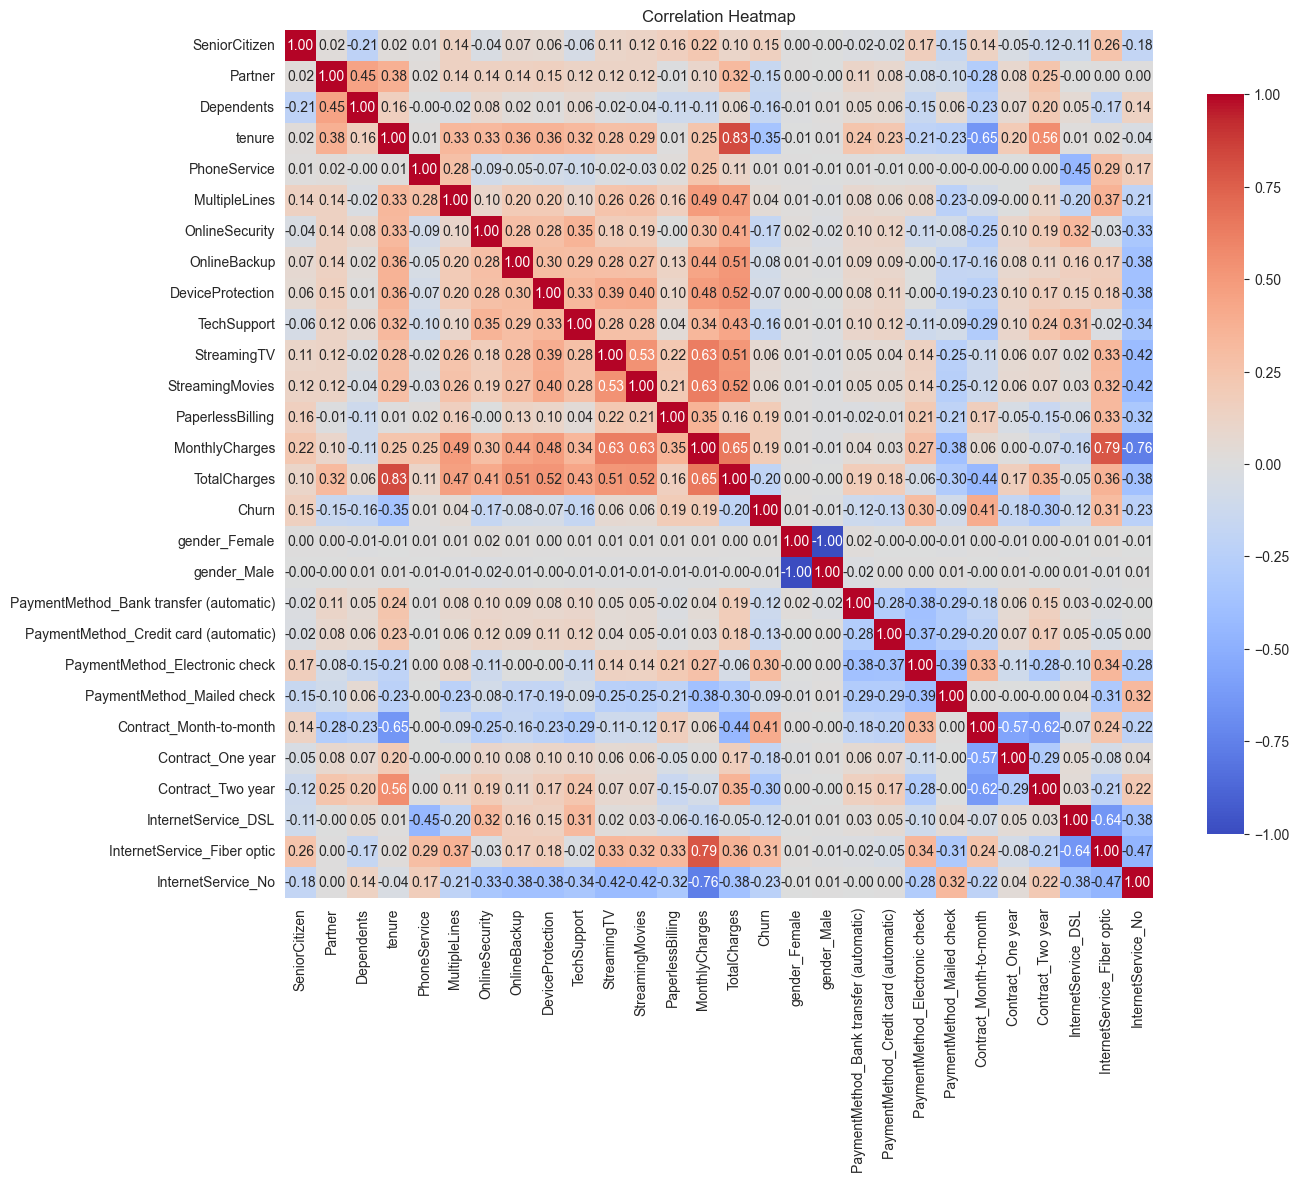

In [34]:
#Heatmap of all variables
corr_matrix = df.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={'shrink': .8})
plt.title('Correlation Heatmap')
plt.show()

In [35]:
#Picking our Xs and Ys
X = df.drop(columns = ['Churn', 'TotalCharges', 'gender_Female', 'PaymentMethod_Mailed check', 'Contract_One year', 'InternetService_No'])
y = df['Churn']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state = 42, stratify=y)

In [37]:
#Estimating the SVC
svc_model = SVC(C=0.7, kernel='poly', degree=2, probability=True, random_state=42)
svc_model.fit(X_train,y_train)
y_pred = svc_model.predict(X_test)
y_prob = svc_model.predict_proba(X_test)[:, 1]

[[1412  140]
 [ 279  282]]
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1552
           1       0.67      0.50      0.57       561

    accuracy                           0.80      2113
   macro avg       0.75      0.71      0.72      2113
weighted avg       0.79      0.80      0.79      2113



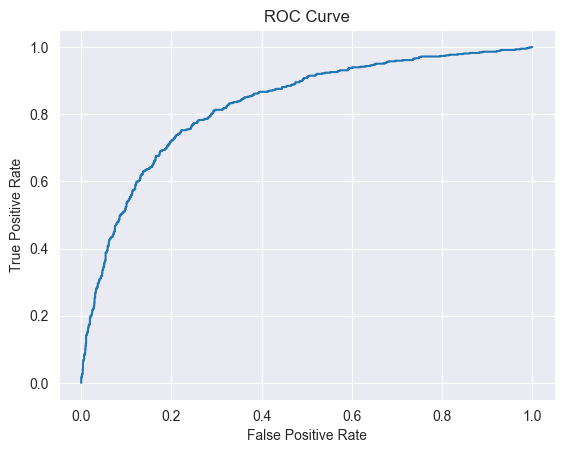

Area Under the ROC Curve (AUC): 0.83


In [38]:
#Performance Assessment
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

auc = roc_auc_score(y_test, y_prob)
print(f"Area Under the ROC Curve (AUC): {auc:.2f}")

In [39]:
from sklearn.ensemble import RandomForestClassifier

# Define X and y
X = df.drop(columns=['Churn', 'TotalCharges', 'gender_Female', 'PaymentMethod_Mailed check', 'Contract_One year', 'InternetService_No'])
y = df['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print a detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1036
           1       0.64      0.46      0.54       373

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409



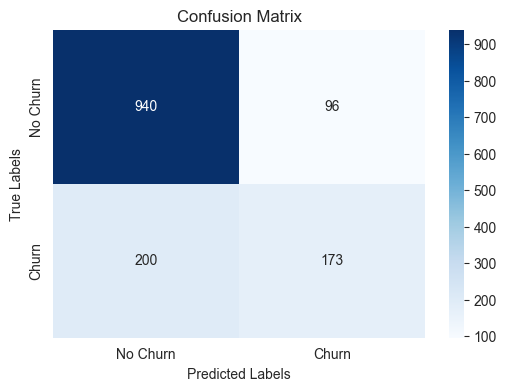

NameError: name 'y_pred_proba' is not defined

In [40]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.2f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()


In [41]:
from sklearn.tree import DecisionTreeClassifier

# Define features and target
X = df.drop(columns=['Churn', 'TotalCharges', 'gender_Female', 'PaymentMethod_Mailed check', 'Contract_One year', 'InternetService_No'])
y = df['Churn']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Decision Tree classifier
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Make predictions
y_pred = dt_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.72
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81      1036
           1       0.48      0.46      0.47       373

    accuracy                           0.72      1409
   macro avg       0.64      0.64      0.64      1409
weighted avg       0.72      0.72      0.72      1409



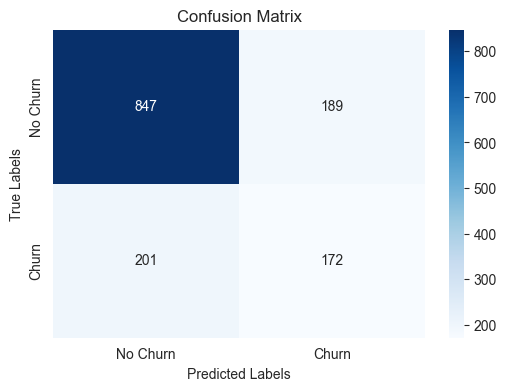

In [42]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Decision Tree AUC: 0.64
Random Forest AUC: 0.83


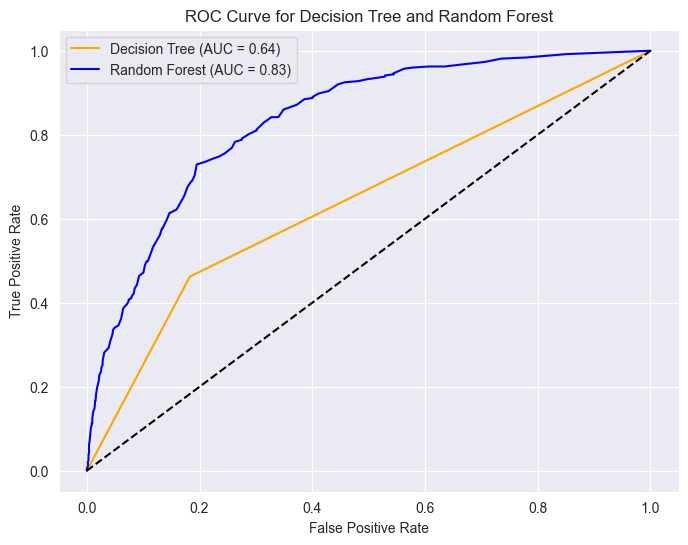

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Define features and target
X = df.drop(columns=['Churn', 'TotalCharges', 'gender_Female', 'PaymentMethod_Mailed check', 'Contract_One year', 'InternetService_No'])
y = df['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize both models
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train both models
dt_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Get probability predictions for ROC-AUC calculation
dt_pred_proba = dt_model.predict_proba(X_test)[:, 1]  # Decision Tree probabilities
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Random Forest probabilities

# Calculate AUC
dt_auc = roc_auc_score(y_test, dt_pred_proba)
rf_auc = roc_auc_score(y_test, rf_pred_proba)
print(f"Decision Tree AUC: {dt_auc:.2f}")
print(f"Random Forest AUC: {rf_auc:.2f}")

# Plot ROC Curves
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_pred_proba)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree (AUC = {dt_auc:.2f})', color='orange')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree and Random Forest')
plt.legend(loc='best')
plt.show()
